In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahwagih/ucf101-videos")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ucf101-videos


### 1. Import module

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import io
import torch.nn as nn
import os
import pandas as pd
import cv2
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from torchvision import transforms
import gc

### Load the dataset

In [2]:
def load_video(path, max_frame=100, size=(480,480)):
    capture = cv2.VideoCapture(path)
    all_frames = []
    while True:
        ret, frame = capture.read()
        if len(all_frames) == max_frame:
            break
        if not ret:
            break
        frame = get_center_square(frame)
        frame = cv2.resize(frame,size)
        frame = frame[:, :, [2,1,0]] # ảnh đọc ra bởi cv2 ở dạng BGR, chuyển về RGB
        frame = torch.tensor(frame)
        frame = frame.permute(2,0,1) # chuyển về channel, height, width
        all_frames.append(frame)
    capture.release()
    return torch.stack(all_frames, dim=0) # dim = (100, 3, size[0], size[1])


"""Get center square of frame"""
def get_center_square(frame):
    y, x = frame.shape[0:2]
    min_lenght = min(x,y)
    start_x = (x//2) - min_lenght//2
    start_y = (y//2) - min_lenght//2
    frame = frame[start_y : start_y + min_lenght, start_x : start_x + min_lenght]
    return frame

In [3]:
folder_path_train = "/kaggle/input/ucf101-videos/train/"
folder_path_test = "/kaggle/input/ucf101-videos/test/"

train_df = pd.read_csv("/kaggle/input/ucf101-videos/train.csv")
test_df = pd.read_csv("/kaggle/input/ucf101-videos/test.csv")

In [4]:
print(train_df['tag'].value_counts())
print(test_df['tag'].value_counts())

tag
Punch           121
PlayingCello    120
CricketShot     118
ShavingBeard    118
TennisSwing     117
Name: count, dtype: int64
tag
CricketShot     49
TennisSwing     49
PlayingCello    44
ShavingBeard    43
Punch           39
Name: count, dtype: int64


#### Create dataframe

In [5]:
def create_dataframe_metadata(df, start, end, label_encoder=None, encode_label=None):
    df_punch = df[df['tag'] == 'Punch']
    df_playCello = df[df['tag'] == 'PlayingCello']
    df_CricketShot = df[df['tag'] == 'CricketShot']
    df_ShavingBeard = df[df['tag'] == 'ShavingBeard']
    df_TennisSwing = df[df['tag'] == 'TennisSwing']
    new_df = pd.concat([df_punch[start:end], df_playCello[start:end], df_CricketShot[start:end], df_ShavingBeard[start:end], df_TennisSwing[start:end]], ignore_index=True)
    new_df['origin_tag'] = new_df['tag']
    if label_encoder is not None:
        new_df['tag'] = label_encoder.fit_transform(new_df['tag'])
    else:
        new_df['tag'] = new_df['tag'].map(encode_label)
    return new_df

In [8]:
label_encoder = LabelEncoder()

In [9]:
df_train = create_dataframe_metadata(train_df, 0, 90, label_encoder=label_encoder)
df_train

,video_name,tag,origin_tag
0,v_Punch_g08_c01.avi,2,Punch
1,v_Punch_g08_c02.avi,2,Punch
2,v_Punch_g08_c03.avi,2,Punch
3,v_Punch_g08_c04.avi,2,Punch
4,v_Punch_g08_c05.avi,2,Punch
...,...,...,...
445,v_TennisSwing_g20_c05.avi,4,TennisSwing
446,v_TennisSwing_g20_c06.avi,4,TennisSwing
447,v_TennisSwing_g21_c01.avi,4,TennisSwing
448,v_TennisSwing_g21_c02.avi,4,TennisSwing


In [10]:
decode_label = dict()
for index, row in df_train.iterrows():
    decode_label.update({row['tag']: row['origin_tag']})
encode_label = {v:k for k,v in decode_label.items()}

In [11]:
df_val = create_dataframe_metadata(train_df, 90, 110, encode_label=encode_label)
df_test = create_dataframe_metadata(test_df, 0, 50, encode_label=encode_label)
df_test

,video_name,tag,origin_tag
0,v_Punch_g01_c01.avi,2,Punch
1,v_Punch_g01_c02.avi,2,Punch
2,v_Punch_g01_c03.avi,2,Punch
3,v_Punch_g01_c04.avi,2,Punch
4,v_Punch_g01_c05.avi,2,Punch
...,...,...,...
219,v_TennisSwing_g07_c03.avi,4,TennisSwing
220,v_TennisSwing_g07_c04.avi,4,TennisSwing
221,v_TennisSwing_g07_c05.avi,4,TennisSwing
222,v_TennisSwing_g07_c06.avi,4,TennisSwing


#### Augumentation dataset

In [12]:
def augmentation_picture(frame):
    transform_a_frame = transforms.Compose([
        # transforms.RandomRotation(degrees=(90,90)), # xoay ảnh 90 90
        transforms.GaussianBlur(kernel_size=11, sigma=1), # làm mờ ảnh nhẹ với vùng ảnh là 11x11
        transforms.RandomErasing(scale=(0.01, 0.1), ratio=(1, 1)) # scale là phạm vi tỷ lệ (min, max) cho vùng xóa so với ảnh ban đầu, ratio là tỉ lệ chiều rộng và cao
    ])
    result = transform_a_frame(frame)
    return result

def augmentation_video(frames):
    new_frames = []
    for frame in frames:
        new_frame = augmentation_picture(frame)
        new_frames.append(new_frame)
    return torch.stack(new_frames,dim=0)

#### Create dataset

In [13]:
class VideoDataset(Dataset):
    def __init__(self, video_paths, img_size=(120,120), all_labels=[], is_train=True):
        self.video_paths = video_paths
        self.img_size = img_size
        self.all_labels = all_labels
        self.new_labels = []
        self.is_train = is_train
        self.data = self.load_data()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.new_labels[index]

    def load_data(self):
        data = []

        for index, path in tqdm(enumerate(self.video_paths)):
            frames = load_video(path, size=self.img_size)
            self.new_labels.append(self.all_labels[index])
            data.append(frames)

            if self.is_train:
                new_frames = augmentation_video(frames)
                data.append(new_frames)
                self.new_labels.append(self.all_labels[index])
        return pad_sequence(data, batch_first=True, padding_value=0)




In [14]:
all_label_train = list(df_train['tag'])
all_label_val = list(df_val['tag'])

In [15]:
train_paths = [os.path.join(folder_path_train, i) for i in df_train['video_name']]
test_paths = [os.path.join(folder_path_test, i) for i in df_test['video_name']]
val_paths = [os.path.join(folder_path_train, i) for i in df_val['video_name']]

In [16]:
load_video(train_paths[10])[0].shape # channel, height, width

torch.Size([3, 480, 480])

100


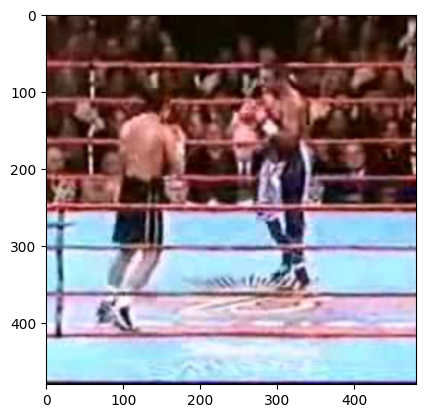

In [17]:
vid0_frame = load_video(val_paths[10])
print(len(vid0_frame))
img_plot_test = vid0_frame[0].permute(1,2,0).numpy() # chuyển về height, width, channel để plot ảnh (224,224,3)
plt.imshow(img_plot_test)

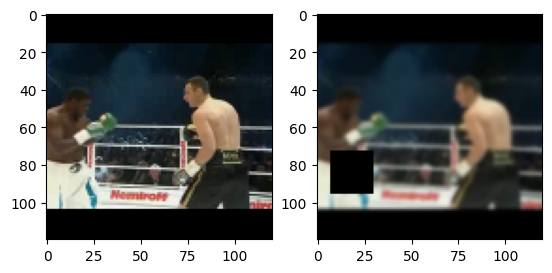

In [18]:
test_augment_path = train_paths[20]
frames_before = load_video(test_augment_path, size=(120,120))
frames_after = augmentation_video(frames_before)

img_after_augment = frames_after[0].permute(1,2,0).numpy()
img_before_augment = frames_before[0].permute(1,2,0).numpy()
fig_aug, ax_aug = plt.subplots(1,2)
ax_aug[0].imshow(img_before_augment)
ax_aug[1].imshow(img_after_augment)

In [19]:
train_dataset = VideoDataset(train_paths, all_labels= all_label_train)
val_dataset = VideoDataset(val_paths, all_labels= all_label_val)
test_dataset = VideoDataset(test_paths, all_labels= list(df_test['tag']), is_train=False)

450it [01:19,  5.66it/s]
100it [00:17,  5.62it/s]
224it [00:09, 23.34it/s]


Punch


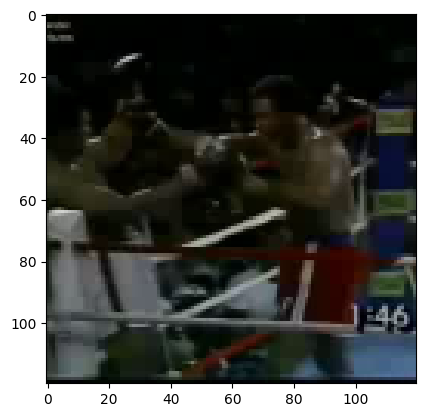

In [20]:
frames, label = train_dataset.__getitem__(100)
print(decode_label[label])
plt.imshow(frames[0].permute(1,2,0).numpy())

In [19]:
# import pickle

# def save_dataset(dataset, path):
#     with open(path, 'wb') as f:
#         pickle.dump(dataset, f)

# def load_dataset(path):
#     with open(path, 'rb') as f:
#         data = pickle.load(f)
#     return data

In [20]:
# save_dataset(train_dataset, "./dataset/train_dataset.pickle")
# save_dataset(val_dataset, "./dataset/val_dataset.pickle")
# save_dataset(test_dataset, "./dataset/test_dataset.pickle")

In [21]:
# train_dataset = load_dataset("./dataset/train_dataset.pickle")
# val_dataset = load_dataset("./dataset/val_dataset.pickle")
# test_dataset = load_dataset("./dataset/test_dataset.pickle")

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Model

In [22]:
def get_cnn_pretrained(model:str = 'resnet50' or 'resnet101' or 'resnet152'):
    if model=='resnet50':
      CNN_pretrained = torchvision.models.resnet50(pretrained = True)
    elif model=='resnet101':
      CNN_pretrained = torchvision.models.resnet101(pretrained = True)
    else:
      CNN_pretrained = torchvision.models.resnet152(pretrained = True)
    CNN_pretrained = torch.nn.Sequential(*list(CNN_pretrained.children())[:8])
    return CNN_pretrained

In [23]:
sample_frames, sample_label = next(iter(val_dataloader))
print(decode_label[int(sample_label[0])])
sample_frames.shape

TennisSwing


torch.Size([32, 100, 3, 120, 120])

In [24]:
Resnet50 = get_cnn_pretrained('resnet50')
Resnet101 = get_cnn_pretrained('resnet101')
Resnet152 = get_cnn_pretrained('resnet152')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [25]:
output_test = Resnet50(sample_frames[:,1].float())
output_test.shape

torch.Size([32, 2048, 4, 4])

In [26]:
output_test = Resnet101(sample_frames[:,1].float())
output_test.shape

torch.Size([32, 2048, 4, 4])

#### CNN-RNN Model

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [28]:
class LSTM(nn.Module):
    def __init__(self, CNNPretrained, hidden_size, num_classes, batch_size):
        super(LSTM, self).__init__()
        self.CNNPretrained = CNNPretrained
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.lstm = nn.LSTM(input_size=(2048*4*4), hidden_size=hidden_size, num_layers=4, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = list()
        for index in range(x.size(1)):
            hidden = torch.zeros((self.batch_size, self.hidden_size))
            frame = x[:, index]

            frame = frame.float()
            with torch.no_grad():
                _x = self.CNNPretrained(frame)
                _x = _x.view(_x.size(0), 2048*4*4)
            input.append(_x)
        input = torch.stack(input, dim=1)

        out1, hidden1 = self.lstm(input)
        res = self.fc1(hidden1[0])
        x = self.fc2(res[0])

        return x

In [29]:
class RNN(nn.Module):
    def __init__(self, CNNPretrained, hidden_size, num_classes, batch_size):
        super(RNN, self).__init__()
        self.CNNPretrained = CNNPretrained
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.batch_size = batch_size

        self.rnn = nn.RNN(input_size=(2048*4*4), hidden_size=hidden_size, num_layers=4, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        input = list()
        for index in range(x.size(1)):
            frame = x[:, index]

            frame = frame.float()
            with torch.no_grad():
                _x = self.CNNPretrained(frame)
                _x = _x.view(_x.size(0), 2048*4*4)
            input.append(_x)
        input = torch.stack(input, dim=1)

        out1, hidden1 = self.rnn(input)
        res = self.fc1(hidden1[0])
        x = self.fc2(res)

        return x

In [30]:
# Thêm patience và delta vào EarlyStopping
class EarlyStopping:
    def __init__(self, path_to_save, delta = 0.01, patience = 3, restore_best_weights=True):
        '''
        delta là tham số kiểm soát độ dao động của loss, loss ở các epoch đầu được phép dao dộng lớn hơn loss ở các epoch về sau
        patience là số lượng epoch mà loss không giảm thì sẽ dừng train
        restore_best_weights là lựa chọn có restore lại weight tốt nhất hay không
        '''
        self.best_val_loss_average = np.inf
        self.best_val_loss = np.inf
        self.path_to_save = path_to_save
        self.early_stop = False
        self.delta = delta
        self.patience = patience
        self.counter = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None

    def __call__(self, current_average_loss_val, current_loss_val,model):
        if current_average_loss_val < self.best_val_loss_average:
            print(f"loss validation average decrease from {self.best_val_loss_average} to {current_average_loss_val}, Saving checkpoint...")
            self.best_val_loss_average = current_average_loss_val
            self.best_val_loss = current_loss_val
            self.counter = 0
            self.best_weights = model.state_dict()
            torch.save(model.state_dict(), self.path_to_save)
        elif current_loss_val < self.best_val_loss:
            print(f"loss validation decrease from {self.best_val_loss} to {current_loss_val}, Saving checkpoint...")
            self.best_val_loss = current_loss_val
            self.counter = 0
            self.best_weights = model.state_dict()
            torch.save(model.state_dict(), self.path_to_save)
        elif current_average_loss_val < self.best_val_loss_average + self.delta*self.best_val_loss_average:
            print(f"loss validation average slightly increased from {self.best_val_loss_average} to {current_average_loss_val}, No save! ")
            self.counter += 1
        else:
            self.counter += 1
            print(f"No improvement. Early stopping counter: {self.counter}/{self.patience}")
        
        # Nếu counter >= patience thì dừng train
        if self.counter >= self.patience:
            print("Early stopping")
            self.early_stop = True
            if self.restore_best_weights and self.best_weights is not None:
                model.load_state_dict(self.best_weights)
                print("Restore best weights")

### Train & Test

In [31]:
# Thêm path_to_save ở hàm train để lưu checkpoint
class Trainer:
    def __init__(self, dataloader_train, dataloader_val, model, optimizer, criterion, epochs=1):
        self.dataloader_train = dataloader_train
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.dataloader_val = dataloader_val
        self.history_average_train_loss = []
        self.history_average_train_acc = []
        self.history_average_val_loss = []
        self.history_average_val_acc = []
        self.history_train_acc = []
        self.epoch_after_early_stop = 1
        self.early_stop_epoch = 0
    def val(self, model_val, device):
        torch.cuda.empty_cache()
        pbar_val = tqdm(self.dataloader_val)
        total_val = 0
        total_correct_val = 0
        all_loss_vall_current = []
        all_acc_vall_current = []
        last_loss_val = np.inf
        for a, b in pbar_val:
            a = a.to(device)
            b = b.to(device)
            out = model_val(a)
            out = out.to(device)
            criterion_val = self.criterion
            loss_val = criterion_val(out, b)
            all_loss_vall_current.append(loss_val.cpu().detach().numpy())
            total_correct_val += (torch.argmax(out, dim=1) == b).sum().item()
            total_val += b.size(0)
            acc_val = total_correct_val/total_val
            all_acc_vall_current.append(acc_val)
            last_loss_val = loss_val
            pbar_val.set_description(f'Acc_val: {acc_val} loss_val {loss_val}')
        loss_val_average = np.average(all_loss_vall_current)
        self.history_average_val_loss.append(loss_val_average)
        self.history_average_val_acc.append(np.average(all_acc_vall_current))
        return loss_val_average, last_loss_val

    def train(self, path_to_save):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = self.model
        model.to(device)
        optimizer = self.optimizer
        criterion = self.criterion
        early_stopping = EarlyStopping( path_to_save, delta=0.1)
        index_after_early_stop = 0
        for epoch in range(self.epochs):
            model.train()
            current_loss_train = []
            current_acc_train = []
            pbar = tqdm(self.dataloader_train)
            total = 0
            total_correct = 0
            print(optimizer.param_groups[0]['lr'])
            for X, y in pbar:
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                X = X.to(device)
                y = y.to(device)
                yh = model(X)
                yh = yh.to(device)
                total_correct += (torch.argmax(yh, dim=1) == y).sum().item()
                total += y.size(0)
                acc = total_correct/total
                loss = criterion(yh, y)
                '''
                Với criterion là CrossEntropyLoss thì thứ tự là output trc rồi đến target
                    vì hàm này yêu cầu chiều của output là (batch_size x class) còn chiều của target là (batch_size)
                '''
                current_loss_train.append(loss.item())
                current_acc_train.append(acc)
                self.history_train_acc.append(acc)
                loss.backward()
                optimizer.step()
                pbar.set_description(f'Epoch: {epoch} Loss: {loss.item()}, Acc: {acc}')
            self.history_average_train_loss.append(np.average(current_loss_train))
            self.history_average_train_acc.append(np.average(current_acc_train))
            current_average_loss_val, current_loss_val = self.val(model.eval(), device)
            print(f"Average loss val: {current_average_loss_val}")
            if early_stopping.early_stop:
                index_after_early_stop += 1
                print(f"epoch {index_after_early_stop} after early stop")
                if index_after_early_stop == self.epoch_after_early_stop:
                    break
                continue
            early_stopping.delta = 1 * (1/(epoch+1)) # điều chỉnh tham số delta theo epoch
            early_stopping(current_average_loss_val, current_loss_val ,model)
            if early_stopping.early_stop:
                print("\n early stop")
                self.early_stop_epoch = epoch


In [32]:
HIDDEN_SIZE = 512
NUM_CLASSES = 5
BATCH_SIZE = 32

In [33]:
# model = LSTM(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE) # thay đổi batch_size nhớ thay cả ở chỗ này
model_resnet50 = RNN(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)
model_resnet101 = RNN(Resnet101, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)
model_resnet152 = RNN(Resnet152, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE).to(device)

In [34]:
test_output = model_resnet50(sample_frames.to(device))
test_output

tensor([[ 0.2505, -0.2158,  0.0536,  0.2998, -0.1984],
        [ 0.2506, -0.2157,  0.0536,  0.2998, -0.1985],
        [-0.1995,  0.0534,  0.0874,  0.3225, -0.2315],
        [-0.8341, -0.0086,  0.0354,  0.5419,  0.2712],
        [-0.1423,  0.1907,  0.1433,  0.0222,  0.1103],
        [-0.0844, -0.4460,  0.2413,  0.2999, -0.0360],
        [-0.7181, -0.3415, -0.1570,  0.2081,  0.4766],
        [-0.1476, -0.3166,  0.1766,  0.6827,  0.1354],
        [-0.4982, -0.1451,  0.2718,  0.5421,  0.4054],
        [-0.0905, -0.3261,  0.4879,  0.3464,  0.0806],
        [-0.3215,  0.0247,  0.4592,  0.1420,  0.2068],
        [ 0.0960,  0.2562,  0.0558,  0.2514,  0.0500],
        [ 0.0019,  0.1007,  0.0759,  0.0595,  0.0113],
        [ 0.2506, -0.2157,  0.0536,  0.2998, -0.1985],
        [-0.1290, -0.0088, -0.0393,  0.3170,  0.1803],
        [-0.0650, -0.3852,  0.1127,  0.5871,  0.4220],
        [-0.2599, -0.1343, -0.1705,  0.3073,  0.5892],
        [-0.3268,  0.0032,  0.2661,  0.3152,  0.3749],
        [ 

In [35]:
def get_trainer(model):
    learning_rate = 1e-4
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    n_epochs = 100
    
    return Trainer(train_dataloader, val_dataloader, model, optimizer, criterion, n_epochs)

In [36]:
trainer_resnet50 = get_trainer(model_resnet50)
trainer_resnet101 = get_trainer(model_resnet101)
trainer_resnet152 = get_trainer(model_resnet152)

In [37]:
torch.cuda.empty_cache()
trainer_resnet50.train("model50-rnn_checkpoint.pt")

  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Acc_val: 0.68 loss_val 0.9677600264549255: 100%|██████████| 7/7 [00:12<00:00,  1.72s/it]              


Average loss val: 0.9398403763771057
loss validation average decrease from inf to 0.9398403763771057, Saving checkpoint...


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 1 Loss: 0.06547880172729492, Acc: 0.9344444444444444: 100%|██████████| 29/29 [00:58<00:00,  2.03s/it]
Acc_val: 0.585 loss_val 0.8103662729263306: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]           


Average loss val: 0.8925666809082031
loss validation average decrease from 0.9398403763771057 to 0.8925666809082031, Saving checkpoint...


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 2 Loss: 0.3635033965110779, Acc: 0.9544444444444444: 100%|██████████| 29/29 [00:58<00:00,  2.03s/it] 
Acc_val: 0.49 loss_val 1.859431266784668: 100%|██████████| 7/7 [00:12<00:00,  1.71s/it]               


Average loss val: 1.4164612293243408
No improvement. Early stopping counter: 1/3


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 3 Loss: 0.23275238275527954, Acc: 0.9566666666666667: 100%|██████████| 29/29 [00:58<00:00,  2.03s/it]
Acc_val: 0.66 loss_val 1.2324261665344238: 100%|██████████| 7/7 [00:11<00:00,  1.71s/it]              


Average loss val: 0.9734636545181274
loss validation average slightly increased from 0.8925666809082031 to 0.9734636545181274, No save! 


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 4 Loss: 0.21270006895065308, Acc: 0.9577777777777777: 100%|██████████| 29/29 [00:58<00:00,  2.03s/it] 
Acc_val: 0.62 loss_val 0.8157070875167847: 100%|██████████| 7/7 [00:12<00:00,  1.71s/it]              


Average loss val: 0.9616852402687073
loss validation average slightly increased from 0.8925666809082031 to 0.9616852402687073, No save! 
Early stopping
Restore best weights

 early stop


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 5 Loss: 0.21964895725250244, Acc: 0.9622222222222222: 100%|██████████| 29/29 [00:58<00:00,  2.03s/it] 
Acc_val: 0.775 loss_val 0.16670143604278564: 100%|██████████| 7/7 [00:12<00:00,  1.71s/it]            

Average loss val: 0.5457826852798462
epoch 1 after early stop


In [43]:
torch.cuda.empty_cache()
trainer_resnet101.train('model101-rnn_checkpoint.pt')

  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 0 Loss: 0.3641212582588196, Acc: 0.7277777777777777: 100%|██████████| 29/29 [01:33<00:00,  3.24s/it]
Acc_val: 0.565 loss_val 1.0935218334197998: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]   


Average loss val: 1.1327515840530396
loss validation average decrease from inf to 1.1327515840530396, Saving checkpoint...


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Acc_val: 0.62 loss_val 1.0229136943817139: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]              


Average loss val: 0.9591673612594604
loss validation average decrease from 1.1327515840530396 to 0.9591673612594604, Saving checkpoint...


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Acc_val: 0.74 loss_val 0.3597923815250397: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]              0s/it]


Average loss val: 0.7239931225776672
loss validation average decrease from 0.9591673612594604 to 0.7239931225776672, Saving checkpoint...


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 3 Loss: 0.2944997251033783, Acc: 0.9611111111111111: 100%|██████████| 29/29 [01:33<00:00,  3.24s/it]  
Acc_val: 0.55 loss_val 1.2436988353729248: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]              


Average loss val: 1.354129433631897
No improvement. Early stopping counter: 1/3


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 4 Loss: 0.1147790476679802, Acc: 0.9622222222222222: 100%|██████████| 29/29 [01:33<00:00,  3.24s/it]  
Acc_val: 0.705 loss_val 0.7703920602798462: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]             


Average loss val: 0.8557458519935608
loss validation average slightly increased from 0.7239931225776672 to 0.8557458519935608, No save! 


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 5 Loss: 0.013179752975702286, Acc: 0.9622222222222222: 100%|██████████| 29/29 [01:33<00:00,  3.23s/it]
Acc_val: 0.68 loss_val 0.6154326796531677: 100%|██████████| 7/7 [00:19<00:00,  2.82s/it]              


Average loss val: 0.8433833718299866
loss validation average slightly increased from 0.7239931225776672 to 0.8433833718299866, No save! 
Early stopping
Restore best weights

 early stop


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 6 Loss: 0.10924135893583298, Acc: 0.9633333333333334: 100%|██████████| 29/29 [01:33<00:00,  3.23s/it] 
Acc_val: 0.69 loss_val 0.882906436920166: 100%|██████████| 7/7 [00:19<00:00,  2.81s/it]               

Average loss val: 0.8268990516662598
epoch 1 after early stop


In [44]:
torch.cuda.empty_cache()
trainer_resnet152.train('model152-rnn_checkpoint.pt')

  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 0 Loss: 0.297184556722641, Acc: 0.7666666666666667: 100%|██████████| 29/29 [02:09<00:00,  4.46s/it]  
Acc_val: 0.54 loss_val 1.4719318151474: 100%|██████████| 7/7 [00:27<00:00,  3.95s/it]                 


Average loss val: 1.2819567918777466
loss validation average decrease from inf to 1.2819567918777466, Saving checkpoint...


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 1 Loss: 0.9812079071998596, Acc: 0.9522222222222222: 100%|██████████| 29/29 [02:09<00:00,  4.46s/it] 
Acc_val: 0.62 loss_val 1.5234489440917969: 100%|██████████| 7/7 [00:27<00:00,  3.95s/it]              


Average loss val: 1.030128002166748
loss validation average decrease from 1.2819567918777466 to 1.030128002166748, Saving checkpoint...


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 2 Loss: 0.7300660014152527, Acc: 0.9588888888888889: 100%|██████████| 29/29 [02:09<00:00,  4.47s/it] 
Acc_val: 0.63 loss_val 0.5096619725227356: 100%|██████████| 7/7 [00:27<00:00,  3.94s/it]              


Average loss val: 0.8630134463310242
loss validation average decrease from 1.030128002166748 to 0.8630134463310242, Saving checkpoint...


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 3 Loss: 0.2035263180732727, Acc: 0.9622222222222222: 100%|██████████| 29/29 [02:08<00:00,  4.42s/it] 
Acc_val: 0.555 loss_val 1.7759555578231812: 100%|██████████| 7/7 [00:27<00:00,  3.95s/it]             


Average loss val: 1.2027158737182617
No improvement. Early stopping counter: 1/3


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 4 Loss: 0.009599841199815273, Acc: 0.9644444444444444: 100%|██████████| 29/29 [02:09<00:00,  4.45s/it]
Acc_val: 0.605 loss_val 0.8248350620269775: 100%|██████████| 7/7 [00:27<00:00,  3.95s/it]             


Average loss val: 0.9527463912963867
loss validation average slightly increased from 0.8630134463310242 to 0.9527463912963867, No save! 


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 5 Loss: 0.3929640054702759, Acc: 0.9622222222222222: 100%|██████████| 29/29 [02:08<00:00,  4.42s/it] 
Acc_val: 0.68 loss_val 0.6149944067001343: 100%|██████████| 7/7 [00:27<00:00,  3.94s/it]              


Average loss val: 0.9690841436386108
loss validation average slightly increased from 0.8630134463310242 to 0.9690841436386108, No save! 
Early stopping
Restore best weights

 early stop


  0%|          | 0/29 [00:00<?, ?it/s]

0.0001


Epoch: 6 Loss: 0.03656740486621857, Acc: 0.9611111111111111: 100%|██████████| 29/29 [02:09<00:00,  4.45s/it]
Acc_val: 0.495 loss_val 1.2518559694290161: 100%|██████████| 7/7 [00:27<00:00,  3.95s/it]             

Average loss val: 1.3660215139389038
epoch 1 after early stop


In [38]:
trainer_resnet50.history_average_val_loss

[0.9398404, 0.8925667, 1.4164612, 0.97346365, 0.96168524, 0.5457827]

In [39]:
import matplotlib.pyplot as plt

def get_plot(trainer, type, model_name):
    plt.title(model_name)
    
    if type == 'loss':
        plt.plot(trainer.history_average_train_loss, label='train loss')
        plt.plot(trainer.history_average_val_loss, label='val loss')
    else:
        plt.plot(trainer.history_average_train_acc, label='train acc')
        plt.plot(trainer.history_average_val_acc, label='val acc')
    plt.axvline(trainer.early_stop_epoch - 3, color='r', linestyle='--', label='early stop')
    plt.legend()
    plt.show()

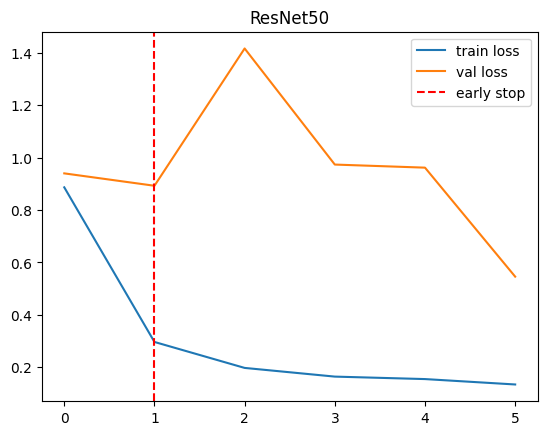

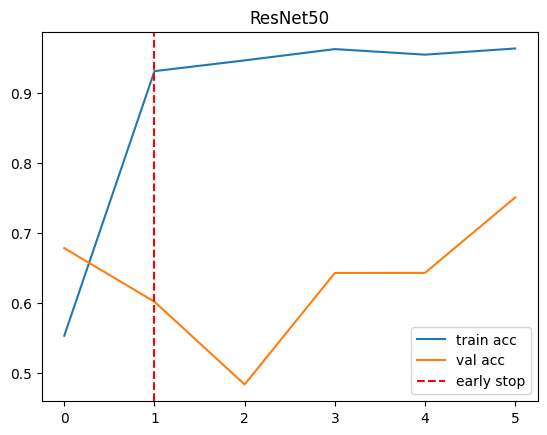

In [40]:
get_plot(trainer_resnet50, "loss", "ResNet50")
get_plot(trainer_resnet50, "acc", "ResNet50")

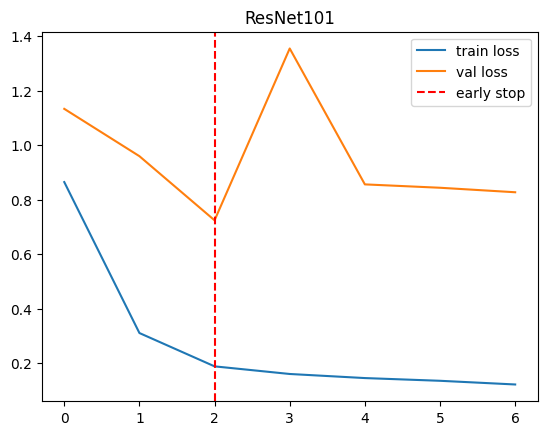

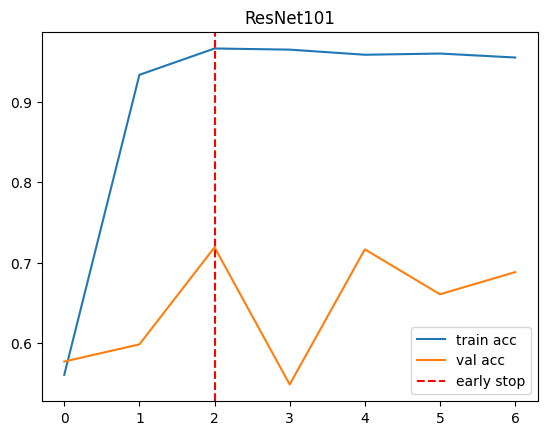

In [45]:
get_plot(trainer_resnet101, "loss", "ResNet101")
get_plot(trainer_resnet101, "acc", "ResNet101")

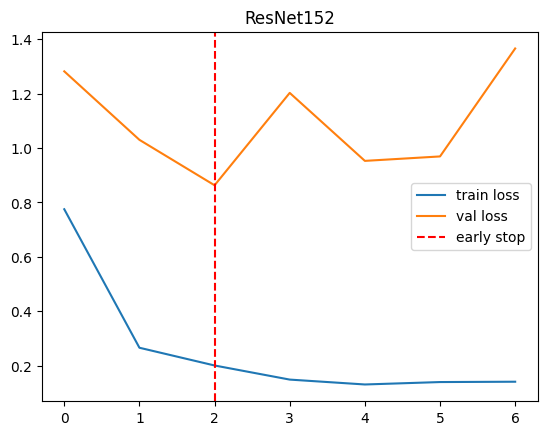

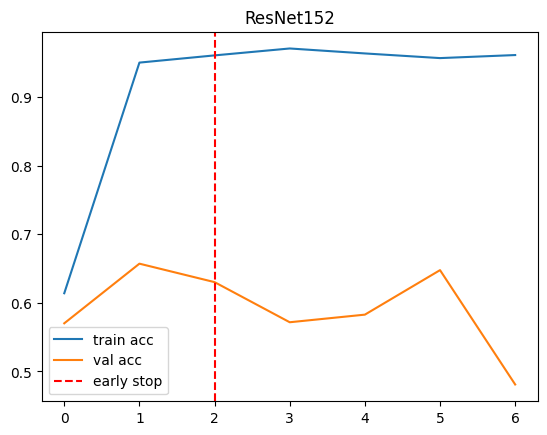

In [46]:
get_plot(trainer_resnet152, "loss", "ResNet152")
get_plot(trainer_resnet152, "acc", "ResNet152")

### Test

In [48]:
class Tester:
    def __init__(self, model, dataloader_test):
        self.dataloader_test = dataloader_test
        self.model = model
    def test(self):
        torch.cuda.empty_cache()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model_test = self.model
        model_test.to(device)
        pbar_test = tqdm(self.dataloader_test)
        total_test = 0
        total_correct_test = 0
        for a, b in pbar_test:
            a = a.to(device)
            b = b.to(device)
            out = model_test(a)
            total_correct_test += (torch.argmax(out, dim=1) == b).sum().item()
            total_test += b.size(0)
            acc_test = total_correct_test/total_test
            pbar_test.set_description(f'Acc_test: {acc_test}')

In [49]:
model_resnet50_save = RNN(Resnet50, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet50_save.load_state_dict(torch.load("./model50-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [50]:
test_resnet50 = Tester(model_resnet50_save, test_dataloader)
test_resnet50.test()

Acc_test: 0.6339285714285714: 100%|██████████| 7/7 [00:12<00:00,  1.85s/it]


In [51]:
model_resnet101_save = RNN(Resnet101, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet101_save.load_state_dict(torch.load("./model101-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [52]:
test_resnet101 = Tester(model_resnet101_save, test_dataloader)
test_resnet101.test()

Acc_test: 0.5803571428571429: 100%|██████████| 7/7 [00:21<00:00,  3.03s/it]


In [53]:
model_resnet152_save = RNN(Resnet152, HIDDEN_SIZE, NUM_CLASSES, BATCH_SIZE)
model_resnet152_save.load_state_dict(torch.load("./model152-rnn_checkpoint.pt", weights_only=True))

<All keys matched successfully>

In [54]:
test_resnet152 = Tester(model_resnet152_save, test_dataloader)
test_resnet152.test()

Acc_test: 0.6294642857142857: 100%|██████████| 7/7 [00:29<00:00,  4.26s/it]
